# Bandits

In this part, we will investigate the properties of the action selection schemes seen in the lecture and compare their properties:

1. greedy action selection
2. $\epsilon$-greedy action selection
3. softmax action selection

Let's re-use the definitions of the last exercise:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()

In [2]:
class Bandit:
    """
    n-armed bandit.
    """
    def __init__(self, nb_actions, mean=0.0, std_Q=1.0, std_r=1.0):
        """
        :param nb_actions: number of arms.
        :param mean: mean of the normal distribution for $Q^*$.
        :param std_Q: standard deviation of the normal distribution for $Q^*$.
        :param std_r: standard deviation of the normal distribution for the sampled rewards.
        """
        # Store parameters
        self.nb_actions = nb_actions
        self.mean = mean
        self.std_Q = std_Q
        self.std_r = std_r
        
        # Initialize the true Q-values
        self.Q_star = rng.normal(self.mean, self.std_Q, self.nb_actions)
        
        # Optimal action
        self.a_star = self.Q_star.argmax()
        
    def step(self, action):
        """
        Sampled a single reward from the bandit.
        
        :param action: the selected action.
        :return: a reward.
        """
        return float(rng.normal(self.Q_star[action], self.std_r, 1))

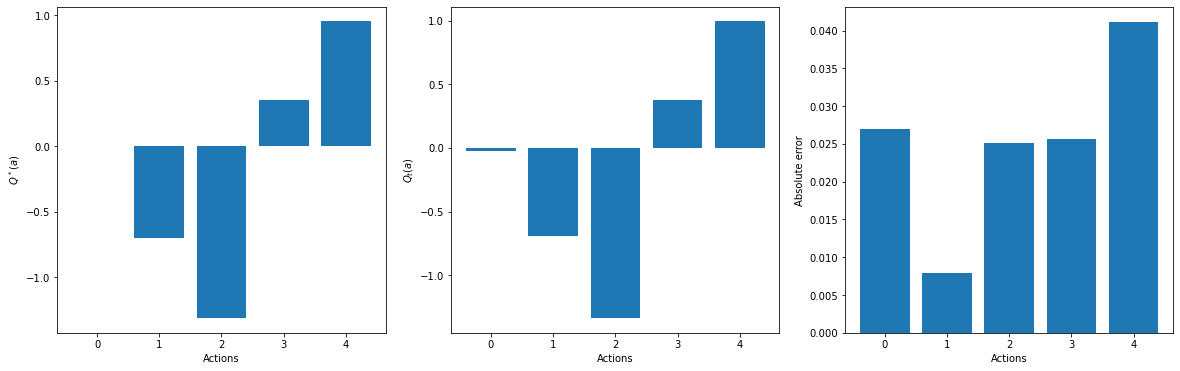

In [3]:
nb_actions = 5
bandit = Bandit(nb_actions)

all_rewards = []
for t in range(1000):
    rewards = []
    for a in range(nb_actions):
        rewards.append(bandit.step(a))
    all_rewards.append(rewards)
    
mean_reward = np.mean(all_rewards, axis=0)

plt.figure(figsize=(20, 6))
plt.subplot(131)
plt.bar(range(nb_actions), bandit.Q_star)
plt.xlabel("Actions")
plt.ylabel("$Q^*(a)$")
plt.subplot(132)
plt.bar(range(nb_actions), mean_reward)
plt.xlabel("Actions")
plt.ylabel("$Q_t(a)$")
plt.subplot(133)
plt.bar(range(nb_actions), np.abs(bandit.Q_star - mean_reward))
plt.xlabel("Actions")
plt.ylabel("Absolute error")
plt.show()

## Greedy action selection

In **greedy action selection**, we systematically chose the action with the highest estimated Q-value at each play (or randomly when there are ties):

$$a_t = \text{argmax}_a Q_t(a)$$

We maintain estimates $Q_t$ of the action values (initialized to 0) using the online formula:

$$Q_{t+1}(a_t) = Q_t(a_t) + \alpha \, (r_{t} - Q_t(a_t))$$

when receiving the sampled reward $r_t$ after taking the action $a_t$. The learning rate $\alpha$ can be set to 0.1 at first.

The algorithm simply alternates between these two steps for 1000 plays (or steps): take an action, update its Q-value. 

**Q:** Implement the greedy algorithm on the 5-armed bandit.

Your algorithm will look like this:

* Create a 5-armed bandit (mean of zero, variance of 1).
* Initialize the estimated Q-values to 0 with an array of the same size as the bandit.
* **for** 1000 plays:
    * Select the greedy action $a_t^*$ using the current estimates.
    * Sample a reward from $\mathcal{N}(Q^*(a_t^*), 1)$.
    * Update the estimated Q-value of the action taken.
    
Additionally, you will store the received rewards at each step in an initially empty list or a numpy array of the correct size and plot it in the end. You will also plot the true Q-values and the estimated Q-values at the end of the 1000 plays. 

*Tip:* to implement the argmax, do not rely on `np.argmax()`. If there are ties in the array, for example at the beginning:

```python
x = np.array([0, 0, 0, 0, 0])
```

`x.argmax()` will return you the **first occurrence** of the maximum 0.0 of the array. In this case it will be the index 0, so you will always select the action 0 first. 

It is much more efficient to retrieve the indices of **all** maxima and randomly select one of them:

```python
a = rng.choice(np.where(x == x.max())[0])
```

`np.where(x == x.max())` returns a list of indices where `x` is maximum. `rng.choice()` randomly selects one of them.

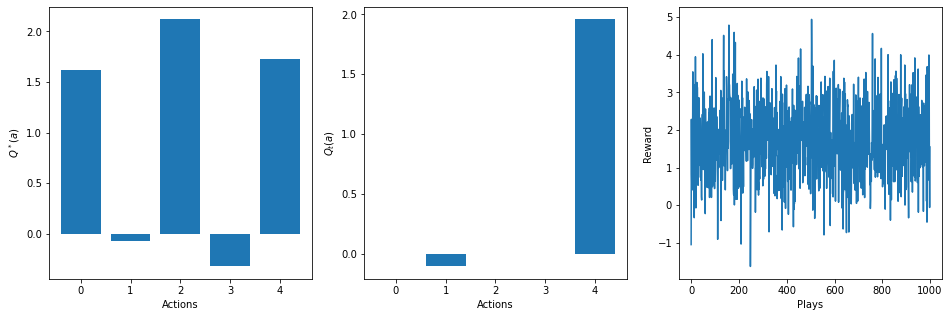

In [4]:
# Learning rate
alpha = 0.1

# Bandit
bandit = Bandit(nb_actions)

# Estimates
Q_t = np.zeros(nb_actions)

# Store the rewards after each step
rewards = []

# For 1000 plays
for step in range(1000):
    
    # Select the action greedily w.r.t Q_t
    action = rng.choice(np.where(Q_t == Q_t.max())[0])
    
    # Sample the reward
    reward = bandit.step(action)
    
    # Store the received reward
    rewards.append(reward)
    
    # Update the Q-value estimate of the action
    Q_t[action] += alpha * (reward - Q_t[action])
    
# Plot the Q-values and the evolution of rewards
plt.figure(figsize=(16, 5))
plt.subplot(131)
plt.bar(range(nb_actions), bandit.Q_star)
plt.xlabel("Actions")
plt.ylabel("$Q^*(a)$")
plt.subplot(132)
plt.bar(range(nb_actions), Q_t)
plt.xlabel("Actions")
plt.ylabel("$Q_t(a)$")
plt.subplot(133)
plt.plot(rewards)
plt.xlabel("Plays")
plt.ylabel("Reward")
plt.show()

**Q:** Re-run your algorithm multiple times with different values of $Q^*$ (simply recreate the `Bandit`) and observe:

1. How much reward you get.
2. How your estimated Q-values in the end differ from the true Q-values.
3. Whether greedy action action selection finds the optimal action or not.

**A:** The plot with rewards is very noisy, you do not really see whether you have learned something because of the randomness of the rewards. More often than not, greedy action selection finds the optimal action, or least a not-that-bad action. The estimates `Q_t` have however nothing to see with the true Q-values, as you quickly select the same action and never update the other ones. 

Before going further, let's turn the agent into a class for better reusability. 

**Q:** Create a `GreedyAgent` class taking the bandit as an argument as well as the learning rate `alpha=0.1`:

```python
bandit = Bandit(nb_actions)

agent = GreedyAgent(bandit, alpha=0.1)
```

The constructor should initialize the array of estimated Q-values `Q_t` and store it as an attribute.

Define a method `act(self)` that returns the index of the greedy action based on the current estimates, as well as a method `update(self, action, reward)` that allows to update the estimated Q-value of the action given the obtained reward. Define also a `train(self, nb_steps)` method that implements the complete training process for `nb_steps=1000` plays.

```python
class GreedyAgent:
    def __init__(self, bandit, alpha):
        # TODO
        
    def act(self):      
        action = # TODO
        return action
        
    def update(self, action, reward):
        # TODO
        
    def train(self, nb_steps):
        # TODO
```

Re-run the experiment using this Greedy agent.

In [5]:
class GreedyAgent:
    
    def __init__(self, bandit, alpha):
        
        self.bandit = bandit
        self.alpha = alpha
        
        # Estimated Q-values
        self.Q_t = np.zeros(self.bandit.nb_actions)
        
    def act(self):
        
        action = rng.choice(np.where(self.Q_t == self.Q_t.max())[0])
        return action
        
    def update(self, action, reward):
        
        self.Q_t[action] += self.alpha * (reward - self.Q_t[action])
    
        
    def train(self, nb_steps):
        
        rewards = []

        for step in range(nb_steps):

            # Select the action 
            action = self.act()

            # Sample the reward
            reward = self.bandit.step(action)

            # Store the received reward
            rewards.append(reward)

            # Update the Q-value estimate of the action
            self.update(action, reward)
            
        return np.array(rewards)

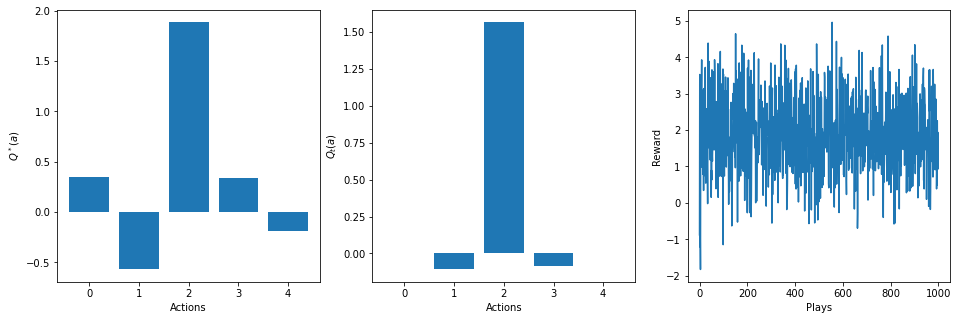

In [6]:
# Learning rate
alpha = 0.1

# Bandit
bandit = Bandit(nb_actions)

# Estimates
agent = GreedyAgent(bandit, alpha)

# Train for 1000 plays
rewards = agent.train(1000)
    
# Plot the Q-values and the evolution of rewards
plt.figure(figsize=(16, 5))
plt.subplot(131)
plt.bar(range(nb_actions), bandit.Q_star)
plt.xlabel("Actions")
plt.ylabel("$Q^*(a)$")
plt.subplot(132)
plt.bar(range(nb_actions), agent.Q_t)
plt.xlabel("Actions")
plt.ylabel("$Q_t(a)$")
plt.subplot(133)
plt.plot(rewards)
plt.xlabel("Plays")
plt.ylabel("Reward")
plt.show()

**Q:** Modify the `train()` method so that it also returns a list of binary values (0 and 1) indicating for each play whether the agent chose the optimal action. Plot this list and observe the lack of exploration.

*Hint:* the index of the optimal action is already stored in the bandit: `bandit.a_star`.

In [7]:
class GreedyAgent:
    def __init__(self, bandit, alpha):
        
        self.bandit = bandit
        self.alpha = alpha
        
        # Estimated Q-values
        self.Q_t = np.zeros(self.bandit.nb_actions)
        
    def act(self):
        
        action = rng.choice(np.where(self.Q_t == self.Q_t.max())[0])
        return action
        
    def update(self, action, reward):
        
        self.Q_t[action] += self.alpha * (reward - self.Q_t[action])
        
    def train(self, nb_steps):
        
        rewards = []
        optimal = []

        for step in range(1000):

            # Select the action 
            action = self.act()

            # Sample the reward
            reward = self.bandit.step(action)

            # Store the received reward
            rewards.append(reward)
            
            # Optimal action
            if action == bandit.a_star:
                optimal.append(1.0)
            else:
                optimal.append(0.0)

            # Update the Q-value estimate of the action
            self.update(action, reward)
            
        return np.array(rewards), np.array(optimal)

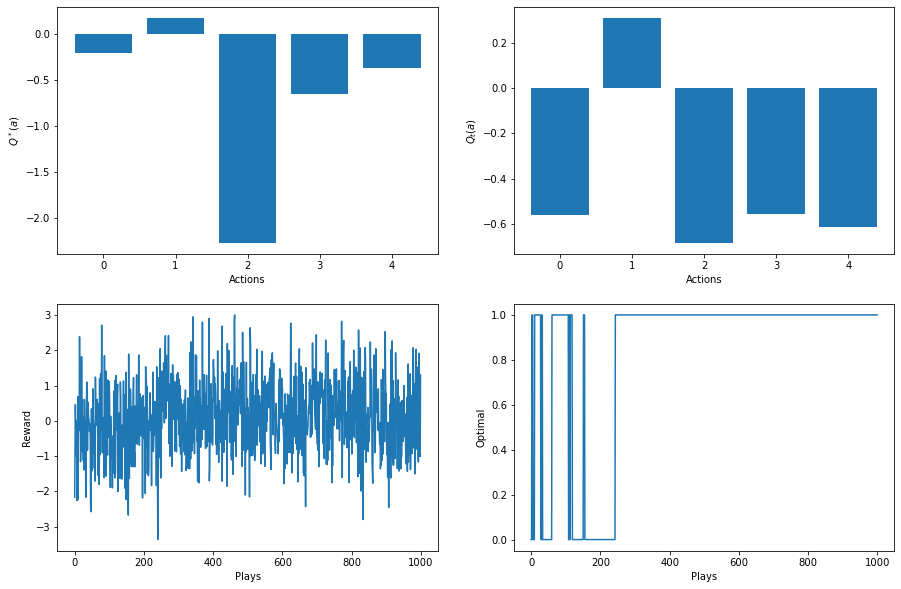

In [8]:
# Learning rate
alpha = 0.1

# Bandit
bandit = Bandit(nb_actions)

# Estimates
agent = GreedyAgent(bandit, alpha)

# Store the rewards after each step
rewards, optimal = agent.train(1000)
    
# Plot the Q-values and the evolution of rewards
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.bar(range(nb_actions), bandit.Q_star)
plt.xlabel("Actions")
plt.ylabel("$Q^*(a)$")
plt.subplot(222)
plt.bar(range(nb_actions), agent.Q_t)
plt.xlabel("Actions")
plt.ylabel("$Q_t(a)$")
plt.subplot(223)
plt.plot(rewards)
plt.xlabel("Plays")
plt.ylabel("Reward")
plt.subplot(224)
plt.plot(optimal)
plt.xlabel("Plays")
plt.ylabel("Optimal")
plt.show()

The evolution of the received rewards and optimal actions does not give a clear indication of the successful learning, as it is strongly dependent on the true Q-values. To truly estimate the performance of the algorithm, we have to average these results over many runs, e.g. 200.

**Q:** Run the learning procedure 200 times (new bandit and agent every time) and average the results. Give a unique name to these arrays (e.g. `rewards_greedy` and `optimal_greedy`) as we will do comparisons later. Compare the results with the lecture, where a 10-armed bandit was used.

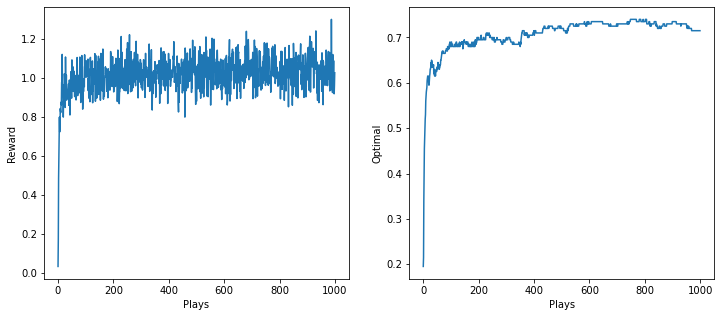

In [9]:
# Number of arms
nb_actions = 5

# Learning rate
alpha = 0.1

rewards_greedy = []
optimal_greedy = []

for trial in range(200):

    # Bandit
    bandit = Bandit(nb_actions)

    # Estimates
    agent = GreedyAgent(bandit, alpha)

    # Store the rewards after each step
    rewards, optimal = agent.train(1000)
    
    rewards_greedy.append(rewards)
    optimal_greedy.append(optimal)
    
rewards_greedy = np.mean(rewards_greedy, axis=0)
optimal_greedy = np.mean(optimal_greedy, axis=0)
    
# Plot the Q-values and the evolution of rewards
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(rewards_greedy)
plt.xlabel("Plays")
plt.ylabel("Reward")
plt.subplot(122)
plt.plot(optimal_greedy)
plt.xlabel("Plays")
plt.ylabel("Optimal")
plt.show()

**A:** the greedy agent selects the optimal action around 80% of the time, vs. 50% for the 10-armed bandits. It is really not bad knowing that it starts at chance level (20% for 5 actions).

## $\epsilon$-greedy action selection

The main drawback of greedy action selection is that it does not explore: as soon as it finds an action better than the others (with a sufficiently positive true Q-value, i.e. where the sampled rewards are mostly positive), it will keep selecting that action and avoid exploring the other options. 

The estimated Q-value of the selected action will end up being quite correct, but those of the other actions will stay at 0.

In $\epsilon$-greedy action selection, the greedy action $a_t^*$ (with the highest estimated Q-value) will be selected with a probability $1-\epsilon$, the others with a probability of $\epsilon$ altogether. 

$$
    \pi(a) = \begin{cases} 1 - \epsilon \; \text{if} \; a = a_t^* \\ \frac{\epsilon}{|\mathcal{A}| - 1} \; \text{otherwise.} \end{cases}
$$

If you have $|\mathcal{A}| = 5$ actions, the four non-greedy actions will be selected with a probability of $\frac{\epsilon}{4}$.

**Q:** Create a `EpsilonGreedyAgent` (possibly inheriting from `GreedyAgent` to reuse code) to implement $\epsilon$-greedy action selection (with $\epsilon=0.1$ at first). Do not overwrite the arrays previously calculated (mean reward and optimal actions), as you will want to compare the two methods in a single plot.

To implement $\epsilon-$greedy, you need to:

1. Select the greedy action $a = a^*_t$.
2. Draw a random number between 0 and 1 (`rng.random()`).
3. If this number is smaller than $\epsilon$, you need to select another action randomly in the remaining ones (`rng.choice()`).
4. Otherwise, keep the greedy action.

In [10]:
class EpsilonGreedyAgent(GreedyAgent):
    
    def __init__(self, bandit, alpha, epsilon):
        
        self.epsilon = epsilon
        
        # List of actions
        self.actions = np.arange(bandit.nb_actions)
        
        # Call the constructor of GreedyAgent
        super().__init__(bandit, alpha)
        
    def act(self):
        
        action = rng.choice(np.where(self.Q_t == self.Q_t.max())[0])
        
        if rng.random() < self.epsilon:
            action = rng.choice(self.actions[self.actions != action])
            
        return action

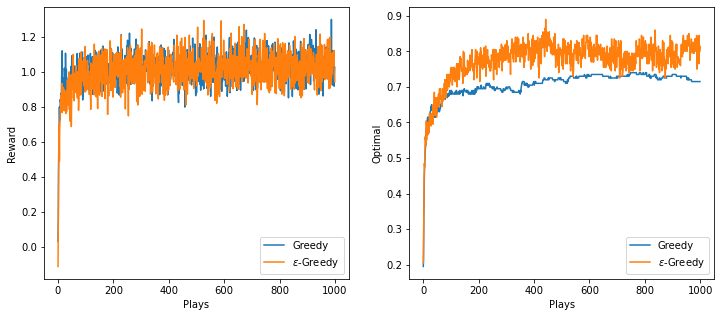

In [11]:
# Number of arms
nb_actions = 5

# Learning rate
alpha = 0.1

# Epsilon for exploration
epsilon = 0.1

rewards_egreedy = []
optimal_egreedy = []

for trial in range(200):

    # Bandit
    bandit = Bandit(nb_actions)

    # Estimates
    agent = EpsilonGreedyAgent(bandit, alpha, epsilon)

    # Store the rewards after each step
    rewards, optimal = agent.train(1000)
    
    rewards_egreedy.append(rewards)
    optimal_egreedy.append(optimal)
    
rewards_egreedy = np.mean(rewards_egreedy, axis=0)
optimal_egreedy = np.mean(optimal_egreedy, axis=0)
    
# Plot the Q-values and the evolution of rewards
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(rewards_greedy, label="Greedy")
plt.plot(rewards_egreedy, label="$\epsilon$-Greedy")
plt.legend()
plt.xlabel("Plays")
plt.ylabel("Reward")
plt.subplot(122)
plt.plot(optimal_greedy, label="Greedy")
plt.plot(optimal_egreedy, label="$\epsilon$-Greedy")
plt.legend()
plt.xlabel("Plays")
plt.ylabel("Optimal")
plt.show()

**Q:** Compare the properties of greedy and $\epsilon$-greedy (speed, optimality, etc). Vary the value of the parameter $\epsilon$ (0.0001 until 0.5) and conclude.

**A:** Depending on the value of $\epsilon$, $\epsilon$-greedy can perform better that greedy in the end, but will necessitate more time at the beginning. If there is too much exploration, $\epsilon$-greedy can be even worse than greedy. 

## Softmax action selection

To avoid exploring actions which are clearly not optimal, another useful algorithm is **softmax action selection**. In this scheme, the estimated Q-values are ransformed into a probability distribution using the softmax opertion:

$$
    \pi(a) = \frac{\exp \frac{Q_t(a)}{\tau}}{ \sum_b \exp \frac{Q_t(b)}{\tau}}
$$ 

For each action, the term $\exp \frac{Q_t(a)}{\tau}$ is proportional to $Q_t(a)$ but made positive. These terms are then normalized by the denominator in order to obtain a sum of 1, i.e. they are the parameters of a discrete probability distribution. The temperature $\tau$ controls the level of exploration just as $\epsilon$ for $\epsilon$-greedy.

In practice, $\exp \frac{Q_t(a)}{\tau}$ can be very huge if the Q-values are high or the temperature is small, creating numerical instability (NaN). It is much more stable to substract the maximal Q-value from all Q-values before applying the softmax:

$$
    \pi(a) = \frac{\exp \displaystyle\frac{Q_t(a) - \max_a Q_t(a)}{\tau}}{ \sum_a \exp \displaystyle\frac{Q_t(a) - \max_a Q_t(a)}{\tau}}
$$ 

This way, $Q_t(a) - \max_a Q_t(a)$ is always negative, so its exponential is between 0 and 1.

**Q:** Implement the softmax action selection (with $\tau=0.5$ at first) and compare its performance to greedy and $\epsilon$-greedy. Vary the temperature $\tau$ and find the best possible value. Conclude.

*Hint:* To select actions with different probabilities, check the doc of `rng.choice()`.

In [12]:
class SoftmaxAgent(GreedyAgent):
    
    def __init__(self, bandit, alpha, tau):
        self.tau = tau
        
        # List of actions
        self.actions = np.arange(bandit.nb_actions)
        
        # Call the constructor of GreedyAgent
        super().__init__(bandit, alpha)
        
    def act(self):
        
        logit = np.exp((self.Q_t - self.Q_t.max())/self.tau)
        
        proba_softmax = logit / np.sum(logit)
        
        action = rng.choice(self.actions, p=proba_softmax) 
            
        return action

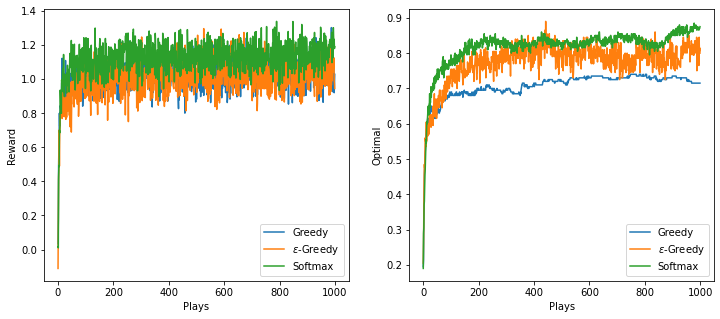

In [13]:
# Number of arms
nb_actions = 5

# Learning rate
alpha = 0.1

# Tau for exploration
tau = 0.1

rewards_softmax = []
optimal_softmax = []

for trial in range(200):

    # Bandit
    bandit = Bandit(nb_actions)

    # Estimates
    agent = SoftmaxAgent(bandit, alpha, tau)

    # Store the rewards after each step
    rewards, optimal = agent.train(1000)
    
    rewards_softmax.append(rewards)
    optimal_softmax.append(optimal)
    
rewards_softmax = np.mean(rewards_softmax, axis=0)
optimal_softmax = np.mean(optimal_softmax, axis=0)
    
# Plot the Q-values and the evolution of rewards
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(rewards_greedy, label="Greedy")
plt.plot(rewards_egreedy, label="$\epsilon$-Greedy")
plt.plot(rewards_softmax, label="Softmax")
plt.legend()
plt.xlabel("Plays")
plt.ylabel("Reward")
plt.subplot(122)
plt.plot(optimal_greedy, label="Greedy")
plt.plot(optimal_egreedy, label="$\epsilon$-Greedy")
plt.plot(optimal_softmax, label="Softmax")
plt.legend()
plt.xlabel("Plays")
plt.ylabel("Optimal")
plt.show()

**A:** softmax loses less time than $\epsilon$-greedy exploring the really bad solutions, so it is optimal earlier. It can be more efficient and optimal than the other methods, but finding the right value for $\tau$ (0.1 works well) is difficult: its optimum value depends on the scaling of Q, you cannot know it in advance...

## Exploration scheduling

The problem with this version of softmax (with a constant temperature) is that even after it has found the optimal action, it will still explore the other ones (although more rarely than at the beginning). The solution is to **schedule** the exploration parameter so that it explores a lot at the beginning (high temperature) and gradually switches to more exploitation (low temperature).

Many schemes are possible for that, the simplest one (**exponential decay**) being to multiply the value of $\tau$ by a number very close to 1 after **each** play:

$$\tau = \tau \times (1 - \tau_\text{decay})$$

**Q:** Implement in a class `SoftmaxScheduledAgent` temperature scheduling for the softmax algorithm ($\epsilon$-greedy would be similar) with $\tau=1$ initially and $\tau_\text{decay} = 0.01$ (feel free to change these values). Plot the evolution of `tau` and of the standard deviation of the choices of the optimal action. Conclude.

In [14]:
class SoftmaxScheduledAgent(SoftmaxAgent):
    
    def __init__(self, bandit, alpha, tau, tau_decay):
        self.tau_decay = tau_decay
        
        self.tau_history = []
        
        # List of actions
        self.actions = np.arange(bandit.nb_actions)
        
        # Call the constructor of GreedyAgent
        super().__init__(bandit, alpha, tau)
    
        
    def act(self):
        
        # Action selection
        logit = np.exp((self.Q_t - self.Q_t.max())/self.tau)
        proba_softmax = logit / np.sum(logit)        
        action = rng.choice(self.actions, p=proba_softmax) 
        
        # Decay tau
        self.tau = self.tau * (1 - self.tau_decay)
        self.tau_history.append(self.tau)
            
        return action

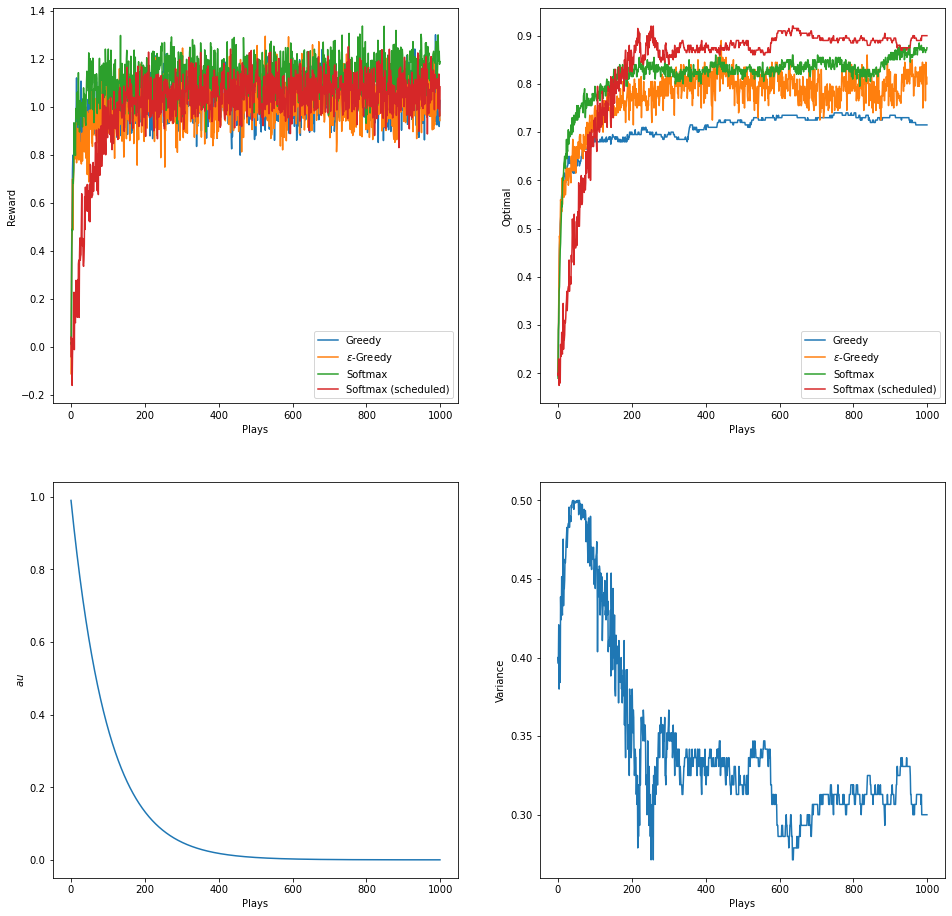

In [15]:
# Learning rate
alpha = 0.1

# Tau for exploration
tau = 1.0
tau_decay = 0.01

rewards_softmaxscheduled = []
optimal_softmaxscheduled = []

for trial in range(200):

    # Bandit
    bandit = Bandit(nb_actions)

    # Estimates
    agent = SoftmaxScheduledAgent(bandit, alpha, tau, tau_decay)

    # Store the rewards after each step
    rewards, optimal = agent.train(1000)
    
    rewards_softmaxscheduled.append(rewards)
    optimal_softmaxscheduled.append(optimal)
    
    
rewards_softmaxscheduled = np.mean(rewards_softmaxscheduled, axis=0)
optimal_softmaxscheduled_std = np.std(optimal_softmaxscheduled, axis=0)
optimal_softmaxscheduled = np.mean(optimal_softmaxscheduled, axis=0)
    
# Plot the Q-values and the evolution of rewards
plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.plot(rewards_greedy, label="Greedy")
plt.plot(rewards_egreedy, label="$\epsilon$-Greedy")
plt.plot(rewards_softmax, label="Softmax")
plt.plot(rewards_softmaxscheduled, label="Softmax (scheduled)")
plt.legend()
plt.xlabel("Plays")
plt.ylabel("Reward")
plt.subplot(222)
plt.plot(optimal_greedy, label="Greedy")
plt.plot(optimal_egreedy, label="$\epsilon$-Greedy")
plt.plot(optimal_softmax, label="Softmax")
plt.plot(optimal_softmaxscheduled, label="Softmax (scheduled)")
plt.legend()
plt.xlabel("Plays")
plt.ylabel("Optimal")
plt.subplot(223)
plt.plot(agent.tau_history)
plt.xlabel("Plays")
plt.ylabel("$\tau$")
plt.subplot(224)
plt.plot(optimal_softmaxscheduled_std)
plt.xlabel("Plays")
plt.ylabel("Variance")
plt.show()

**A:** Scheduling drastically improves how often the optimal action is selected. In terms of mean reward, the difference is not that big, as there is often a "second best" action whose expected reward is close. We can see that the variance of the optimal action selection follows the parameter $\tau$.

**Q:** Experiment with different schedules (initial values, decay rate) and try to find the best setting.

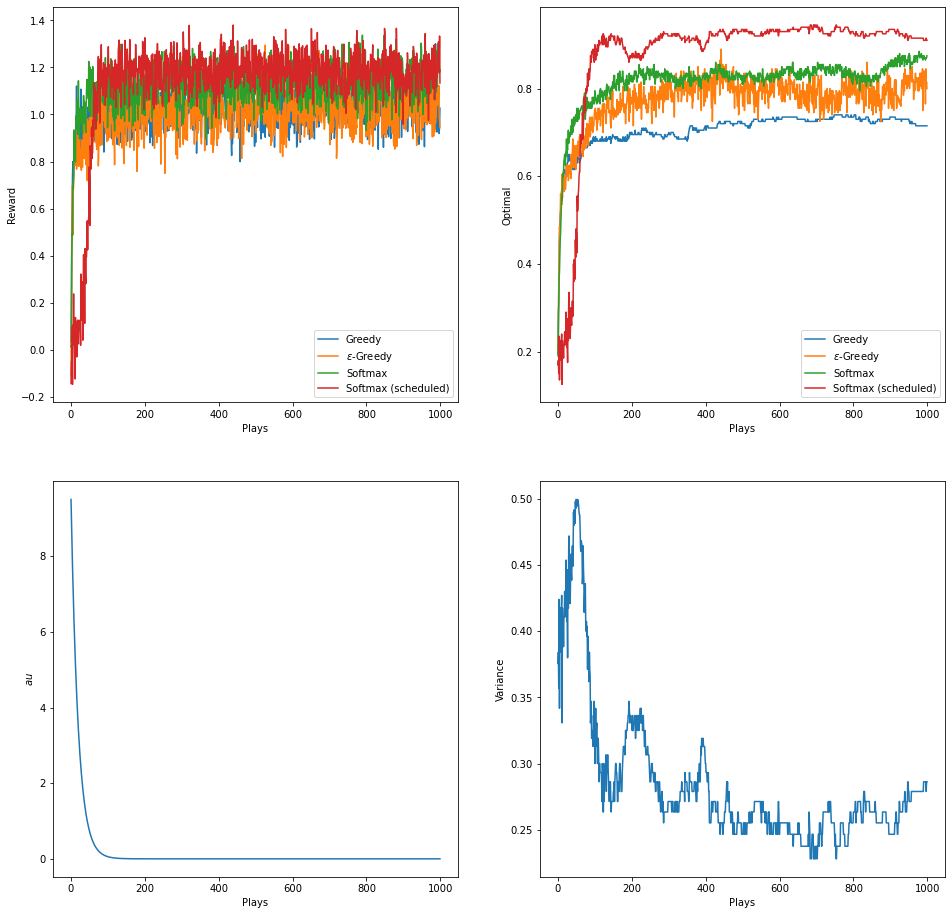

In [17]:
# Learning rate
alpha = 0.1

# Tau for exploration
tau = 10.0
tau_decay = 0.05

rewards_softmaxscheduled = []
optimal_softmaxscheduled = []

for trial in range(200):

    # Bandit
    bandit = Bandit(nb_actions)

    # Estimates
    agent = SoftmaxScheduledAgent(bandit, alpha, tau, tau_decay)

    # Store the rewards after each step
    rewards, optimal = agent.train(1000)
    
    rewards_softmaxscheduled.append(rewards)
    optimal_softmaxscheduled.append(optimal)
    
    
rewards_softmaxscheduled = np.mean(rewards_softmaxscheduled, axis=0)
optimal_softmaxscheduled_std = np.std(optimal_softmaxscheduled, axis=0)
optimal_softmaxscheduled = np.mean(optimal_softmaxscheduled, axis=0)
    
# Plot the Q-values and the evolution of rewards
plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.plot(rewards_greedy, label="Greedy")
plt.plot(rewards_egreedy, label="$\epsilon$-Greedy")
plt.plot(rewards_softmax, label="Softmax")
plt.plot(rewards_softmaxscheduled, label="Softmax (scheduled)")
plt.legend()
plt.xlabel("Plays")
plt.ylabel("Reward")
plt.subplot(222)
plt.plot(optimal_greedy, label="Greedy")
plt.plot(optimal_egreedy, label="$\epsilon$-Greedy")
plt.plot(optimal_softmax, label="Softmax")
plt.plot(optimal_softmaxscheduled, label="Softmax (scheduled)")
plt.legend()
plt.xlabel("Plays")
plt.ylabel("Optimal")
plt.subplot(223)
plt.plot(agent.tau_history)
plt.xlabel("Plays")
plt.ylabel("$\tau$")
plt.subplot(224)
plt.plot(optimal_softmaxscheduled_std)
plt.xlabel("Plays")
plt.ylabel("Variance")
plt.show()

**A:** no unique answer here, but a very high exploration parameter initially which decreases quite fast leads to very performant solutions. Take-home message: scheduling is very important, but it is quite difficult to find the optimal schedule.